In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import tqdm

import torch 

import sklearn
import sklearn.covariance
from sklearn import svm

import matplotlib.pyplot as plt

/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import re

In [3]:
from icd9cms.icd9 import search

with open("./data/pcode_dict.txt", "rb") as fp: 
    icd9_pcode_dict = pickle.load(fp)

In [4]:
from transformers import AutoTokenizer
NTDBGPT2_tokenizer = AutoTokenizer.from_pretrained('dracoglacius/NTDB-GPT2')

## Overview

We have the intuition that given a distribution with center of the hyper-elliposid $c$ and the shape of the ellipsoid defined by $\Sigma$, $c$ and $\sigma$ should not deviate from the empirical mean ($\hat{c}$) and the covariance estimations ($\hat{\Sigma}$) taken from the training data. 

To obtain these estimates we need to:

1. Feed the NTDB model with the training data (length $n$) and from the last token get the features of each layer ($n$ x 13 x 768)
1. Calculate the sample mean ($\hat{c}$) and the covariance estimate ($\hat{\Sigma}$), while also getting the estimated pseudo-inverse (called `.precision_` in sklearn)

To obtain the OOD estimation we need to:

1. Calculate the Mahalanobis Distance Feature (MDF) using the generated data (should be a vector equal to the number of layers)
1. Calculate the Anomaly Score
  1. This is a one-class SVM with a linear kernel with MDF as features

## Helper Functions

In [5]:
def metric(dir_name, stypes = ['Bas', 'Gau'], verbose=False):
    tp, fp, tnr_at_tpr95 = get_curve(dir_name, stypes)
    results = dict()
    mtypes = ['TNR', 'AUROC', 'DTACC', 'AUIN', 'AUOUT']
    if verbose:
        print('      ', end='')
        for mtype in mtypes:
            print(' {mtype:6s}'.format(mtype=mtype), end='')
        print('')
        
    for stype in stypes:
        if verbose:
            print('{stype:5s} '.format(stype=stype), end='')
        results[stype] = dict()
        
        # TNR
        mtype = 'TNR'
        results[stype][mtype] = tnr_at_tpr95[stype]
        if verbose:
            print(' {val:6.3f}'.format(val=100.*results[stype][mtype]), end='')
        
        # AUROC
        mtype = 'AUROC'
        tpr = np.concatenate([[1.], tp[stype]/tp[stype][0], [0.]])
        fpr = np.concatenate([[1.], fp[stype]/fp[stype][0], [0.]])
        results[stype][mtype] = -np.trapz(1.-fpr, tpr)
        if verbose:
            print(' {val:6.3f}'.format(val=100.*results[stype][mtype]), end='')
        
        # DTACC
        mtype = 'DTACC'
        results[stype][mtype] = .5 * (tp[stype]/tp[stype][0] + 1.-fp[stype]/fp[stype][0]).max()
        if verbose:
            print(' {val:6.3f}'.format(val=100.*results[stype][mtype]), end='')
        
        # AUIN
        mtype = 'AUIN'
        denom = tp[stype]+fp[stype]
        denom[denom == 0.] = -1.
        pin_ind = np.concatenate([[True], denom > 0., [True]])
        pin = np.concatenate([[.5], tp[stype]/denom, [0.]])
        results[stype][mtype] = -np.trapz(pin[pin_ind], tpr[pin_ind])
        if verbose:
            print(' {val:6.3f}'.format(val=100.*results[stype][mtype]), end='')
        
        # AUOUT
        mtype = 'AUOUT'
        denom = tp[stype][0]-tp[stype]+fp[stype][0]-fp[stype]
        denom[denom == 0.] = -1.
        pout_ind = np.concatenate([[True], denom > 0., [True]])
        pout = np.concatenate([[0.], (fp[stype][0]-fp[stype])/denom, [.5]])
        results[stype][mtype] = np.trapz(pout[pout_ind], 1.-fpr[pout_ind])
        if verbose:
            print(' {val:6.3f}'.format(val=100.*results[stype][mtype]), end='')
            print('')
    return results

In [6]:
def get_curve(dir_name, stypes = ['Baseline', 'Gaussian_LDA']):
    tp, fp = dict(), dict()
    tnr_at_tpr95 = dict()
    for stype in stypes:
        known = np.loadtxt('{}/confidence_{}_In.txt'.format(dir_name, stype), delimiter='\n')
        novel = np.loadtxt('{}/confidence_{}_Out.txt'.format(dir_name, stype), delimiter='\n')
        known.sort()
        novel.sort()
        end = np.max([np.max(known), np.max(novel)])
        start = np.min([np.min(known),np.min(novel)])
        num_k = known.shape[0]
        num_n = novel.shape[0]
        tp[stype] = -np.ones([num_k+num_n+1], dtype=int)
        fp[stype] = -np.ones([num_k+num_n+1], dtype=int)
        tp[stype][0], fp[stype][0] = num_k, num_n
        k, n = 0, 0
        for l in range(num_k+num_n):
            if k == num_k:
                tp[stype][l+1:] = tp[stype][l]
                fp[stype][l+1:] = np.arange(fp[stype][l]-1, -1, -1)
                break
            elif n == num_n:
                tp[stype][l+1:] = np.arange(tp[stype][l]-1, -1, -1)
                fp[stype][l+1:] = fp[stype][l]
                break
            else:
                if novel[n] < known[k]:
                    n += 1
                    tp[stype][l+1] = tp[stype][l]
                    fp[stype][l+1] = fp[stype][l] - 1
                else:
                    k += 1
                    tp[stype][l+1] = tp[stype][l] - 1
                    fp[stype][l+1] = fp[stype][l]
        tpr95_pos = np.abs(tp[stype] / num_k - .95).argmin()
        tnr_at_tpr95[stype] = 1. - fp[stype][tpr95_pos] / num_n
    return tp, fp, tnr_at_tpr95

In [7]:
def detection_performance(scores, Y, outf, tag='TMP'):
    """
    Measure the detection performance
    return: detection metrics
    """
    os.makedirs(outf, exist_ok=True)
    num_samples = scores.shape[0]
    l1 = open('%s/confidence_%s_In.txt'%(outf, tag), 'w')
    l2 = open('%s/confidence_%s_Out.txt'%(outf, tag), 'w')
    y_pred = scores # regressor.predict_proba(X)[:, 1]

    for i in range(num_samples):
        if Y[i] == 0:
            l1.write("{}\n".format(-y_pred[i]))
        else:
            l2.write("{}\n".format(-y_pred[i]))
    l1.close()
    l2.close()
    results = metric(outf, [tag])
    return results

## MDF Functions

In [8]:
def get_empirical_mean_cov(cov_estimator, layer_embeddings, num_layers=13):
    mean_list = []
    precision_list = []

    for l in tqdm.tqdm(range(num_layers)):
        sample_mean = torch.mean(layer_embeddings[:,l,:], axis=0)
        X = layer_embeddings[:,l,:] - sample_mean
        cov_estimator.fit(X.numpy())
        temp_precision = cov_estimator.precision_
        temp_precision = torch.from_numpy(temp_precision).float()
        mean_list.append(sample_mean)#.to(device))
        precision_list.append(temp_precision)#.to(device))
    return mean_list, precision_list

In [9]:
def get_mdf(test_layer_embeddings, layer_mean, layer_precision, num_layers=13):
    mdf_list = []
    
    for l in tqdm.tqdm(range(num_layers)):
        zero_f = test_layer_embeddings[:,l,:] - layer_mean[l]
        gaussian_score = -0.5 * ((zero_f @ layer_precision[l]) @ zero_f.t()).diag()
        mdf_list.append(gaussian_score)
    
    return torch.stack(mdf_list).transpose(1,0)

In [10]:
def get_score(trn_mdf, test_mdf, ood_mdf, label):
    
    candidate_list = [1e-15, 1e-12, 1e-9, 1e-7, 1e-5, 1e-3, 0.01, 0.1, 0.2, 0.5, 1]

    ood_labels = np.ones(shape=(ood_mdf.shape[0], ))
    test_labels = np.zeros(shape=(test_mdf.shape[0], ))

    np.random.shuffle(test_mdf)
    np.random.shuffle(ood_mdf)
    best_ours_results = None
    best_ours_AUROC = 0.0
    best_model = None
    # for k in ['poly', 'linear']:
    for k in ['linear']:
        for nuu in tqdm.tqdm(candidate_list):
            print ("running ---:", "kernel:", k, "nuu:", nuu)
            
            c_lr = svm.OneClassSVM(nu=nuu, kernel=k, degree=2, tol=1e-5)
            #c_lr = sklearn.linear_model.SGDOneClassSVM(nu=nuu, random_state=42)
            c_lr.fit(trn_mdf)
            
            test_scores = c_lr.score_samples(test_mdf)
            ood_scores = c_lr.score_samples(ood_mdf)
            X_scores = np.concatenate((ood_scores, test_scores))
            Y_test = np.concatenate((ood_labels, test_labels))

            results = detection_performance(X_scores, Y_test, 'mah_logs', tag='TMP')
            neg_resuls = detection_performance(-X_scores, Y_test, 'feats_logs', tag='TMP')
            if sum(results["TMP"].values()) < sum(neg_resuls["TMP"].values()):
                results = neg_resuls

            if results['TMP']['AUROC'] > best_ours_AUROC:
                best_ours_AUROC = results['TMP']['AUROC']
                best_ours_results = results
                best_hypers = '{}-{}'.format(k, nuu)
                # save data for plotting
                best_model = c_lr
                d = {"X_scores": X_scores, "Y_test": Y_test, "Features": np.concatenate((test_scores, ood_scores))}
    mtypes = ['AUROC', 'DTACC', 'AUIN', 'AUOUT']
    for mtype in mtypes:
        print(' {mtype:6s}'.format(mtype=mtype), end='')
    print('\n{val:6.2f}'.format(val=100.*best_ours_results['TMP']['AUROC']), end='')
    print(' {val:6.2f}'.format(val=100.*best_ours_results['TMP']['DTACC']), end='')
    print(' {val:6.2f}'.format(val=100.*best_ours_results['TMP']['AUIN']), end='')
    print(' {val:6.2f}\n'.format(val=100.*best_ours_results['TMP']['AUOUT']), end='')
    print("best hyper %s"%(best_hypers)) 
    print ("saving data for plotting")
    with open("./outputs/{}_{}.pkl".format('NTDB', label), "wb") as f:
        pickle.dump(d, f)
    print('-------------------------------')
    
    return d, best_model

In [11]:
def plot_scores(score_df, ft='X_scores'):
    plt.hist(score_df[score_df['Y_test']==1][ft], 100, alpha=0.7, label='Out of Distribution')
    plt.hist(score_df[score_df['Y_test']==0][ft], 100, alpha=0.7, label='In-Distribution')
    plt.legend(loc='upper right')
    plt.show()

In [12]:
def print_seq_dsc(seq):
    cds = seq.split()
    tp = 'START'
    for c in cds:
        if c == '<START>':
            print('=' * 9 + ' START ' + '=' * 9)
        elif c == '<DSTART>':
            tp = 'DX'
            print('=' * 10 + ' DXS ' + '=' * 10)
        elif c == '<PSTART>':
            tp = 'PR'
            print('=' * 10 + ' PRS ' + '=' * 10)
        elif c == '<END>':
            print('=' * 10 + ' END ' + '=' * 10)
        elif c == '<UNK>':
            print(f'{c}:Unknown Code')
        else:
            if tp == 'DX':
                d = search(c)
                if d:
                    print(d)
            if tp == 'PR':
                pr_cd = re.sub(r'\.', '', c)
                if pr_cd in icd9_pcode_dict:
                    print(f"{pr_cd}:{icd9_pcode_dict[pr_cd]}")
                else:
                    print(f'{pr_cd}:Unknown Code')

# Configurations

In [13]:
PRINT_SEQUENCES = 20
TRN_FRAC = 0.9

## Load Data

In [14]:
def filter_token_length(sequences, tok_len=19):
    filtered_sequences = []
    for seq in sequences:
        seq_ids = NTDBGPT2_tokenizer.encode(seq, return_tensors='pt')
        if len(seq_ids[0]) < 20:
            filtered_sequences.append(seq)
    return filtered_sequences

In [15]:
trn_seq = np.load("./data/25k_train_seqs_3_22_E8859_E8120_E9660_E9654_E9240.npy")

e8120_trn_seq = filter_token_length([x for x in trn_seq if 'E812.0' in x]) # 5000 items
e8859_trn_seq = filter_token_length([x for x in trn_seq if 'E885.9' in x]) # 5000 items
e9660_trn_seq = filter_token_length([x for x in trn_seq if 'E966.0' in x]) # 5000 items
e9654_trn_seq = filter_token_length([x for x in trn_seq if 'E965.4' in x]) # 5000 items
e9240_trn_seq = filter_token_length([x for x in trn_seq if 'E924.0' in x]) # 5000 items

# E812.0 vs E965.4

#### E812.0 Common Data

In [16]:
e8120_trn_all_token_layer_embeddings = np.load("./outputs/e8120_trn_all_em.npy", allow_pickle=True)
e8120_trn_end_token_layer_embeddings = torch.stack([x[-1,:,:] for x in e8120_trn_all_token_layer_embeddings])

e8120_trn_end_token_layer_embeddings = e8120_trn_end_token_layer_embeddings[:int(len(e8120_trn_end_token_layer_embeddings)*TRN_FRAC),:,:]
e8120_tst_end_token_layer_embeddings = e8120_trn_end_token_layer_embeddings[int(len(e8120_trn_end_token_layer_embeddings)*TRN_FRAC):,:,:]

cov_estimator1 = sklearn.covariance.EmpiricalCovariance(assume_centered=False)

e8120_trn_end_token_mean, e8120_trn_end_token_inv_cov = get_empirical_mean_cov(cov_estimator1, e8120_trn_end_token_layer_embeddings)
e8120_trn_mdf = get_mdf(torch.Tensor(e8120_trn_end_token_layer_embeddings), e8120_trn_end_token_mean, e8120_trn_end_token_inv_cov)
e8120_tst_mdf = get_mdf(torch.Tensor(e8120_tst_end_token_layer_embeddings), e8120_trn_end_token_mean, e8120_trn_end_token_inv_cov)

100%|██████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 266.51it/s]


In [18]:
e9654_trn_all_token_layer_embeddings = np.load("./outputs/e9654_trn_all_em.npy", allow_pickle=True)
e9654_trn_end_token_layer_embeddings = torch.stack([x[-1,:,:] for x in e9654_trn_all_token_layer_embeddings])

e8120_e9654_ood_mdf = get_mdf(torch.Tensor(e9654_trn_end_token_layer_embeddings), e8120_trn_end_token_mean, e8120_trn_end_token_inv_cov)

100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 20.73it/s]


In [19]:
e8120_e9654_score, e8120_e9654_det = get_score(e8120_trn_mdf, e8120_tst_mdf, e8120_e9654_ood_mdf, 'E8120_E9654_TRN')

/tmp/ipykernel_257551/963709382.py:8: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/tmp/ipykernel_257551/963709382.py:9: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)
 36%|███████████████████████▎                                        | 4/11 [00:00<00:00, 32.32it/s]

running ---: kernel: linear nuu: 1e-15
running ---: kernel: linear nuu: 1e-12
running ---: kernel: linear nuu: 1e-09
running ---: kernel: linear nuu: 1e-07
running ---: kernel: linear nuu: 1e-05
running ---: kernel: linear nuu: 0.001
running ---: kernel: linear nuu: 0.01


 73%|██████████████████████████████████████████████▌                 | 8/11 [00:00<00:00, 23.74it/s]

running ---: kernel: linear nuu: 0.1
running ---: kernel: linear nuu: 0.2
running ---: kernel: linear nuu: 0.5
running ---: kernel: linear nuu: 1


/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  8.23it/s]

 AUROC  DTACC  AUIN   AUOUT 
100.00 100.00  99.86  99.99
best hyper linear-1e-15
saving data for plotting
-------------------------------


In [20]:
e8120_e9654_score_df = pd.DataFrame(e8120_e9654_score)

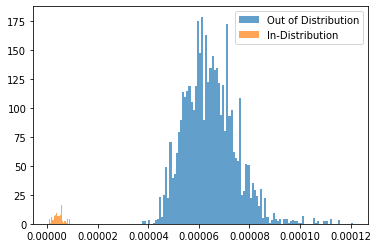

In [21]:
plot_scores(e8120_e9654_score_df)

In [27]:
y1 = e8120_e9654_det.score_samples(e8120_e9654_ood_mdf)

In [28]:
split1 = 0.00002

In [29]:
e8120_e9654_normal = []
for i,o in enumerate(y1):
    if o < split1:
        e8120_e9654_normal.append((i,o))

In [30]:
e8120_e9654_anomaly = []
for i,o in enumerate(y1):
    if o >= split1:
        e8120_e9654_anomaly.append((i,o))

In [31]:
print('Normal:', len(e8120_e9654_normal), 'Anomaly:', len(e8120_e9654_anomaly))

Normal: 0 Anomaly: 4206


# E812.0 vs E924.0

In [35]:
e9240_trn_all_token_layer_embeddings = np.load("./outputs/e9240_trn_all_em.npy", allow_pickle=True)
e9240_trn_end_token_layer_embeddings = torch.stack([x[-1,:,:] for x in e9240_trn_all_token_layer_embeddings])

e8120_e9240_ood_mdf = get_mdf(torch.Tensor(e9240_trn_end_token_layer_embeddings), e8120_trn_end_token_mean, e8120_trn_end_token_inv_cov)

100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.64it/s]


In [36]:
e8120_e9240_score, e8120_e9240_det = get_score(e8120_trn_mdf, e8120_tst_mdf, e8120_e9240_ood_mdf, 'E8120_E9240_TRN')

/tmp/ipykernel_257551/963709382.py:8: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/tmp/ipykernel_257551/963709382.py:9: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)
 27%|█████████████████▍                                              | 3/11 [00:00<00:00, 28.48it/s]

running ---: kernel: linear nuu: 1e-15
running ---: kernel: linear nuu: 1e-12
running ---: kernel: linear nuu: 1e-09
running ---: kernel: linear nuu: 1e-07
running ---: kernel: linear nuu: 1e-05
running ---: kernel: linear nuu: 0.001


 55%|██████████████████████████████████▉                             | 6/11 [00:00<00:00, 28.60it/s]

running ---: kernel: linear nuu: 0.01
running ---: kernel: linear nuu: 0.1
running ---: kernel: linear nuu: 0.2


 82%|████████████████████████████████████████████████████▎           | 9/11 [00:00<00:00, 14.30it/s]

running ---: kernel: linear nuu: 0.5
running ---: kernel: linear nuu: 1


/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.54it/s]

 AUROC  DTACC  AUIN   AUOUT 
100.00 100.00  99.86  99.99
best hyper linear-1e-15
saving data for plotting
-------------------------------


In [37]:
e8120_e9240_score_df = pd.DataFrame(e8120_e9240_score)

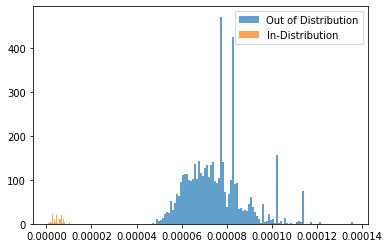

In [38]:
plot_scores(e8120_e9240_score_df)

In [42]:
y2 = e8120_e9240_det.score_samples(e8120_e9240_ood_mdf)

In [43]:
split2 = 0.00002

In [44]:
e8120_e9240_normal = []
for i,o in enumerate(y2):
    if o < split2:
        e8120_e9240_normal.append((i,o))

In [45]:
e8120_e9240_anomaly = []
for i,o in enumerate(y2):
    if o >= split2:
        e8120_e9240_anomaly.append((i,o))

In [46]:
print('Normal:', len(e8120_e9240_normal), 'Anomaly:', len(e8120_e9240_anomaly))

Normal: 0 Anomaly: 4889


# E965.4 vs E924.0

#### E965.4 Common Data

In [47]:
e9654_trn_all_token_layer_embeddings = np.load("./outputs/e9654_trn_all_em.npy", allow_pickle=True)
e9654_trn_end_token_layer_embeddings = torch.stack([x[-1,:,:] for x in e9654_trn_all_token_layer_embeddings])

e9654_trn_end_token_layer_embeddings = e9654_trn_end_token_layer_embeddings[:int(len(e9654_trn_end_token_layer_embeddings)*TRN_FRAC),:,:]
e9654_tst_end_token_layer_embeddings = e9654_trn_end_token_layer_embeddings[int(len(e9654_trn_end_token_layer_embeddings)*TRN_FRAC):,:,:]

cov_estimator1 = sklearn.covariance.EmpiricalCovariance(assume_centered=False)

e9654_trn_end_token_mean, e9654_trn_end_token_inv_cov = get_empirical_mean_cov(cov_estimator1, e9654_trn_end_token_layer_embeddings)
e9654_trn_mdf = get_mdf(torch.Tensor(e9654_trn_end_token_layer_embeddings), e9654_trn_end_token_mean, e9654_trn_end_token_inv_cov)
e9654_tst_mdf = get_mdf(torch.Tensor(e9654_tst_end_token_layer_embeddings), e9654_trn_end_token_mean, e9654_trn_end_token_inv_cov)

100%|██████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 386.81it/s]


In [48]:
e9240_trn_all_token_layer_embeddings = np.load("./outputs/e9240_trn_all_em.npy", allow_pickle=True)
e9240_trn_end_token_layer_embeddings = torch.stack([x[-1,:,:] for x in e9240_trn_all_token_layer_embeddings])

e9654_e9240_ood_mdf = get_mdf(torch.Tensor(e9240_trn_end_token_layer_embeddings), e9654_trn_end_token_mean, e9654_trn_end_token_inv_cov)

100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.68it/s]


In [49]:
e9654_e9240_score, e9654_e9240_det = get_score(e9654_trn_mdf, e9654_tst_mdf, e9654_e9240_ood_mdf, 'E9654_E9240_TRN')

/tmp/ipykernel_257551/963709382.py:8: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/tmp/ipykernel_257551/963709382.py:9: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)
 27%|█████████████████▍                                              | 3/11 [00:00<00:00, 28.20it/s]

running ---: kernel: linear nuu: 1e-15
running ---: kernel: linear nuu: 1e-12
running ---: kernel: linear nuu: 1e-09
running ---: kernel: linear nuu: 1e-07
running ---: kernel: linear nuu: 1e-05
running ---: kernel: linear nuu: 0.001


 55%|██████████████████████████████████▉                             | 6/11 [00:00<00:00, 28.62it/s]

running ---: kernel: linear nuu: 0.01
running ---: kernel: linear nuu: 0.1
running ---: kernel: linear nuu: 0.2


 82%|████████████████████████████████████████████████████▎           | 9/11 [00:00<00:00, 13.57it/s]

running ---: kernel: linear nuu: 0.5
running ---: kernel: linear nuu: 1


/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.03it/s]

 AUROC  DTACC  AUIN   AUOUT 
100.00 100.00  99.87  99.99
best hyper linear-1e-15
saving data for plotting
-------------------------------


In [50]:
e9654_e9240_score_df = pd.DataFrame(e9654_e9240_score)

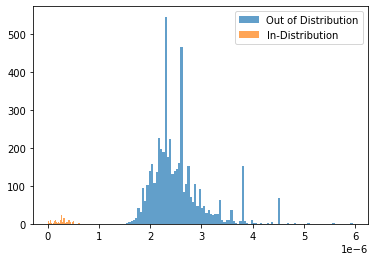

In [51]:
plot_scores(e9654_e9240_score_df)

In [53]:
y3 = e9654_e9240_det.score_samples(e9654_e9240_ood_mdf)

In [52]:
split3 = 1.

In [54]:
e9654_e9240_normal = []
for i,o in enumerate(y3):
    if o < split3:
        e9654_e9240_normal.append((i,o))

In [55]:
e9654_e9240_anomaly = []
for i,o in enumerate(y3):
    if o >= split3:
        e9654_e9240_anomaly.append((i,o))

In [56]:
print('Normal:', len(e9654_e9240_normal), 'Anomaly:', len(e9654_e9240_anomaly))

Normal: 4889 Anomaly: 0
